# TLC Trip Record Project

Project Goal: The aim of this project is to engineer the end-to-end data flow of Yellow taxi trip records (ETL Process)\
Dataset Link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page\
Data dictionary: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

# Import Modules

In [1]:
import os
import sys
import warnings
import pandas as pd
from credentials import *
import snowflake.connector
from PIL import Image
from urllib.request import urlopen
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

# Options and Settings

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')

# Load Image

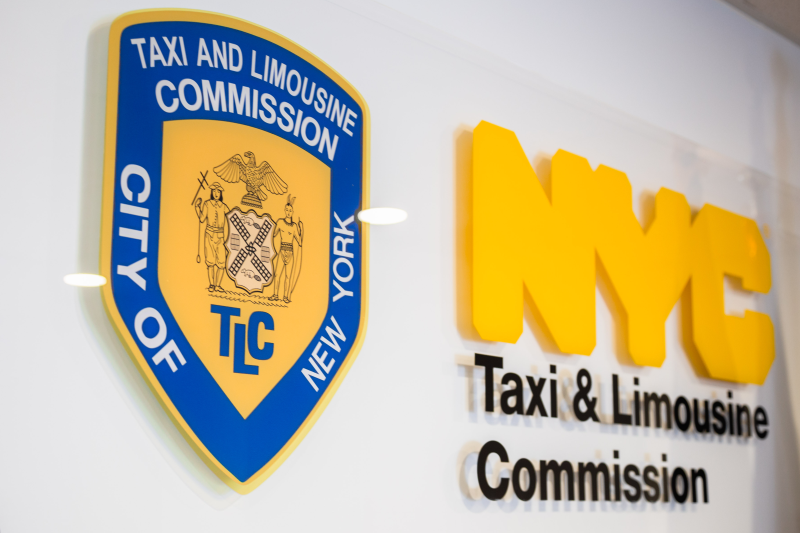

In [3]:
image_url = "https://www.nyc.gov/assets/tlc/images/content/pages/about/about-tlc.png"
Image.open(fp=urlopen(f'{image_url}'))

# Connect To Snowflake

In [4]:
def conn(**db_parameters):
    """
    Connect to Snowflake using the login parameters

    https://github.com/snowflakedb/snowflake-sqlalchemy#escaping-special-characters-such-as---signs-in-passwords

    """
    try:
        engine = create_engine(URL(**db_parameters))
        return engine.connect()
    
    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"
    
    finally:
        engine.connect().close()
        engine.dispose()

cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, warehouse=WAREHOUSE)

In [5]:
def my_conn_setup(db_name: str, schema_name: str, table_name: str, stage_name: str, format_name: str, on_error: str, purge: bool = False):
    """
    Creates new database, schema, table and stage

    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    table_name: str
        Specifies the identifier (i.e. name) for the table; must be unique for the schema in which the table is created.

    stage_name: str
        Specifies the identifier for the stage; must be unique for the schema in which the stage is created.

    format_name: str
        Specifies the type of files for the stage

    on_error: str
        String (constant) that specifies the error handling for the load operation, defaults to 'ABORT_STATEMENT'

    purge: bool, defaults to 'True'
        Boolean that specifies whether to remove the data files from the stage automatically after the data is loaded successfully.


    """   
    create_db_query = f"""CREATE OR REPLACE DATABASE {db_name}"""
    create_schema_query = f"""CREATE SCHEMA IF NOT EXISTS {schema_name}"""
    create_table_query = f"""CREATE TABLE IF NOT EXISTS {table_name} (
                                                                        VendorID VARCHAR,
                                                                        tpep_pickup_datetime VARCHAR,
                                                                        tpep_dropoff_datetime VARCHAR,
                                                                        Passenger_count  VARCHAR,
                                                                        Trip_distance VARCHAR,
                                                                        PULocationID VARCHAR,
                                                                        DOLocationID VARCHAR,
                                                                        RateCodeID VARCHAR,
                                                                        Store_and_fwd_flag VARCHAR,
                                                                        Payment_type VARCHAR,
                                                                        Fare_amount VARCHAR,
                                                                        Extra_category VARCHAR,
                                                                        MTA_tax VARCHAR,
                                                                        Improvement_surcharge VARCHAR,
                                                                        Tip_amount VARCHAR,
                                                                        Tolls_amount VARCHAR,
                                                                        Total_amount VARCHAR,
                                                                        Congestion_Surcharg VARCHAR,
                                                                        Airport_fee VARCHAR
                                                                      )
                          """
    
    create_stage_query = f"""CREATE STAGE IF NOT EXISTS {stage_name}
                             FILE_FORMAT = (TYPE = '{format_name}')
                             COPY_OPTIONS = (ON_ERROR = '{on_error}')
                             COPY_OPTIONS = (PURGE = {purge})
                             
                          """
    
    try:
        cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, warehouse=WAREHOUSE)
        cnx.execute(statement=create_db_query)
        cnx.execute(statement=create_schema_query)
        cnx.execute(statement=create_table_query)
        cnx.execute(statement=create_stage_query)

        cnx.execute(f"USE DATABASE {db_name}")
        cnx.execute(f"USE SCHEMA {schema_name}")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)

my_conn_setup(
               db_name="NYC_TLC", schema_name="TLC_Trip_Record", table_name="yellow_taxi", stage_name="yellow_taxi_local", format_name="PARQUET",\
               on_error="ABORT_STATEMENT", purge=False
            )

# Copying Multiple Data from an Internal Location

In [6]:
def load_data(db_name: str, schema_name: str, table_name: str, path_to_file: str, stage_name: str):
    """
    Load data into existing table

    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    path_to_file: str
        path_to_file is the local directory path of the file(s) to upload.

    stage_name: str
        Specifies the location in Snowflake where to upload the files

    """   
    upload_file_query = f"""PUT file://{path_to_file} @{stage_name}"""
    
    load_data_query = f"""COPY INTO {table_name}
                          FROM @{stage_name}
                          MATCH_BY_COLUMN_NAME=CASE_INSENSITIVE
                          
                       """
    
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=upload_file_query)
        cnx.execute(statement=load_data_query)

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


load_data(
    db_name="NYC_TLC", 
    schema_name="TLC_Trip_Record",
    table_name="yellow_taxi", 
    path_to_file=os.path.join(os.getcwd(), "Datasets", "TLC_Trip_Record", "*.parquet"),
    stage_name="yellow_taxi_local"
)

# Query Table

In [7]:
db_name = "NYC_TLC"
schema_name = "TLC_Trip_Record"
table_name = "yellow_taxi"

cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
results = cnx.execute(f"""SELECT DISTINCT * FROM {table_name}""").fetchall()

df = pd.DataFrame(results)